## Import modules

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

## Load data

In [3]:
forests = pd.read_csv('forests.csv')

In [4]:
forests.columns

Index(['temp', 'humid', 'wind', 'rain', 'FFMC', 'DMC', 'DC', 'ISI', 'BUI',
       'FWI', 'region', 'fire'],
      dtype='object')

## Final clean

In [5]:
forests = forests.dropna()

In [6]:
forests.temp = forests.temp.astype(int)

In [7]:
forests["fire"] = forests["fire"].apply(lambda x: x.replace("\\", ""))

## Check multicollinearity with a heatmap

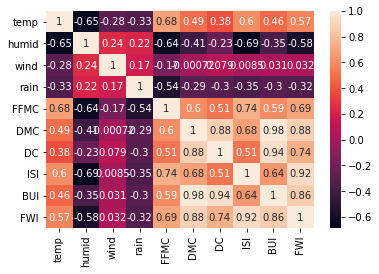

In [8]:
corr_grid = forests.corr()
sns.heatmap(corr_grid, xticklabels = corr_grid.columns, yticklabels = corr_grid.columns, annot = True)
plt.show()

## Plot humidity vs temperature

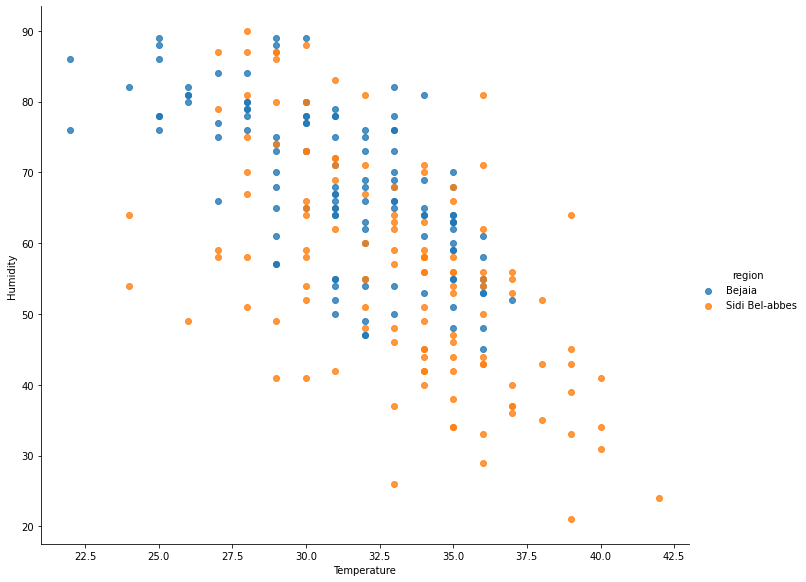

In [24]:
g = sns.lmplot(data = forests,
               x = "temp",
               y = "humid",
               hue = "region",
               fit_reg = False,
               height = 8,
               aspect = 1.2)

g.set_ylabels("Humidity")
g.set_xlabels("Temperature")

## Fit model predicting humidity

In [10]:
modelH = sm.OLS.from_formula("humid ~ temp + region", data = forests).fit()
modelH.params

Intercept                   142.575801
region[T.Sidi Bel-abbes]     -7.247538
temp                         -2.392547
dtype: float64

Regression equations for each region

Bejaia
- humid = 142.6 - 2.39 * temp - 7.24 * region
- humid = 142.6 - 2.39 * temp - 7.24 * 0
- humid = 142.6 - 2.39 * temp

Sidi Bel-abbes
- humid = 142.6 - 2.39 * temp - 7.24 * region
- humid = 142.6 - 2.39 * temp - 7.24 * 1
- humid = 142.6 - 7.24 - 2.39 * temp
- humid = 135.4 - 2.39 * temp

These regions have the same negative gradient but different intercepts, suggesting that these regression lines would parallel but with Bejaia having consistently higher humidity.

With all other predictors held constant, humidity drops 2.39 units for every degree increase in temperature in both places.



## Plot regression lines

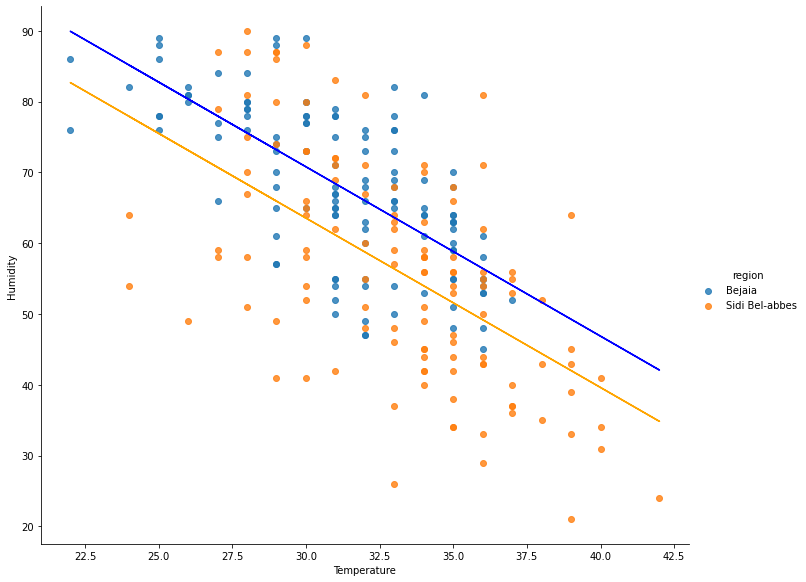

In [23]:
g = sns.lmplot(data = forests,
               x = "temp",
               y = "humid",
               hue = "region",
               fit_reg = False,
               height = 8,
               aspect = 1.2)

#plot Bejaia line
plt.plot(forests.temp, modelH.params[0] + modelH.params[2]*forests.temp, color = "blue")

#plot Side Bel-abbes
plt.plot(forests.temp, modelH.params[0] + modelH.params[1] + modelH.params[2]*forests.temp, color = "orange")

g.set_ylabels("Humidity")
g.set_xlabels("Temperature")

## Predicting FFMC interaction: (Fine Fuel Moisture Code)

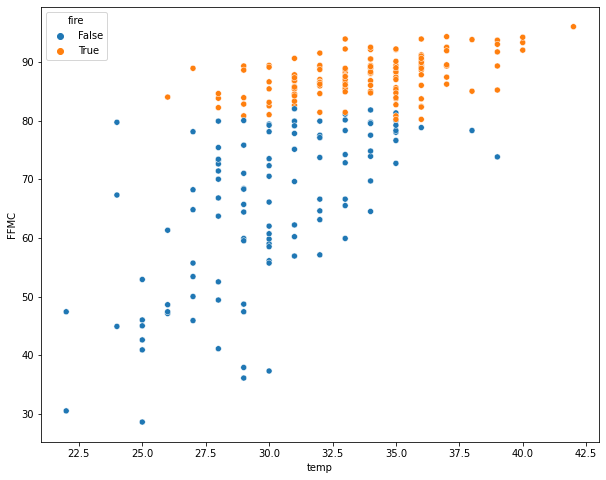

In [12]:
fig = plt.figure(figsize = (10, 8))
sns.scatterplot(x = "temp", y = "FFMC", hue = "fire", data = forests)
plt.show()

## Fit model predicting FFMC with temp and fire

In [14]:
model = sm.OLS.from_formula("FFMC ~ temp + fire + temp*fire", data = forests)
resultsF = model.fit()
resultsF.params

Intercept            -8.108891
fire[T.True]         76.788000
temp                  2.445159
temp:fire[T.True]    -1.887219
dtype: float64

The full regression equation is:

FFMC = - 8.1 + 76.8 * fire(True) + 2.4 * temp - 1.88 * temp * fire(True)

For fire = True:
- FFMC = -8.1 + (76.8 * 1) + 2.4 * temp - (1.88 * temp * 1)
- FFMC = -8.1 + 76.8 + 2.4 * temp - 1.88 * temp
- FFMC =  68.7 + 0.52 * temp

For fire = False:
- FFMC = -8.1 + (76.8 * 0) + 2.4 * temp - (1.88 * temp * 0)
- FFMC = -8.1 + 2.4 * temp

Coefficient analysis:
- Where fire is True, temp coefficient is much smaller (just over 20%) of the coefficient of when fire was False. Suggesting that the gradient of the no-fire category is steeper. 

For fire = True:
- FFMC went up 0.52 units for every degree temperature increase.

For FFMC = False:
- FFMC went up 2.4 units for every degree temperature increase.

## Plot regression lines

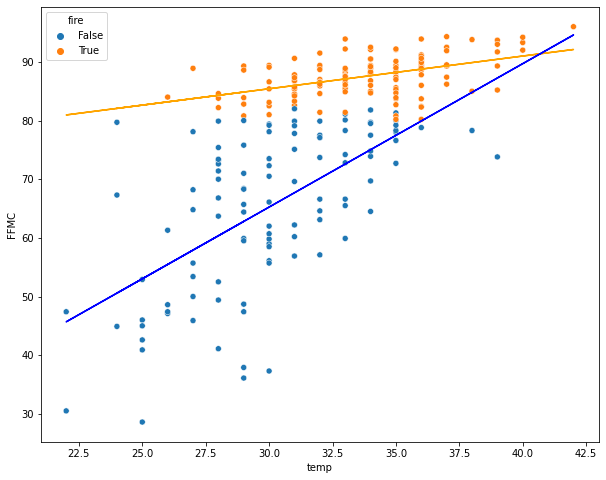

In [16]:
fig = plt.figure(figsize = (10, 8))
sns.scatterplot(x = "temp", y = "FFMC", hue = "fire", data = forests)

#plot fires = True
plt.plot(forests.temp, resultsF.params[0] + (resultsF.params[1]*1) + resultsF.params[2]*forests.temp + (resultsF.params[3]*forests.temp*1), color = "orange")

#plot fires = False
plt.plot(forests.temp, resultsF.params[0] + (resultsF.params[1]*0) + resultsF.params[2]*forests.temp + (resultsF.params[3]*forests.temp*0), color = "blue")

plt.show()

## FFMC from humidity

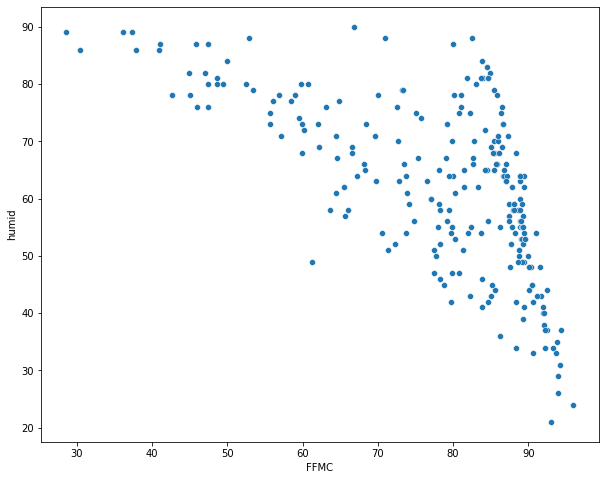

In [17]:
fig = plt.figure(figsize = (10, 8))
sns.scatterplot(x = "FFMC", y = "humid", data = forests)
plt.show()

The above scatterplot shows a curved/non-linear relationship between FFMC and humidity.

## FFMC from humidity raised to second power

In [21]:
model = sm.OLS.from_formula("FFMC ~ humid + np.power(humid, 2)", data = forests)
resultsP = model.fit()
resultsP.params

Intercept             77.634041
humid                  0.752165
np.power(humid, 2)    -0.011420
dtype: float64

In [25]:
#FFMC from 25% humidity
ffmc_25 = resultsP.params[0] + resultsP.params[1]*25 + resultsP.params[2]*25

#FFMC from 35% humidity
ffmc_35 = resultsP.params[0] + resultsP.params[1]*35 + resultsP.params[2]*35

#FFMC from 60% humidity
ffmc_60 = resultsP.params[0] + resultsP.params[1]*60 + resultsP.params[2]*60

#FFMC from 70% humidity
ffmc_70 = resultsP.params[0] + resultsP.params[1]*70 + resultsP.params[2]*70

print(ffmc_25, ffmc_35)
print(ffmc_60, ffmc_70)

96.15266574398744 103.56011565809999
122.07874044338134 129.48619035749388


With the polynomial function there is a similar difference between a range at the lower end of the values and a range at the higher range of the values. This would be inpossible with a straight line from looking at the scatterplot.

## FFMC from humidity, temperature, wind and rain

In [26]:
modelWR = sm.OLS.from_formula("FFMC ~ humid + temp + wind + rain", data = forests).fit()
modelWR.params

Intercept    50.461574
humid        -0.345373
temp          1.377774
wind          0.419784
rain         -2.614067
dtype: float64

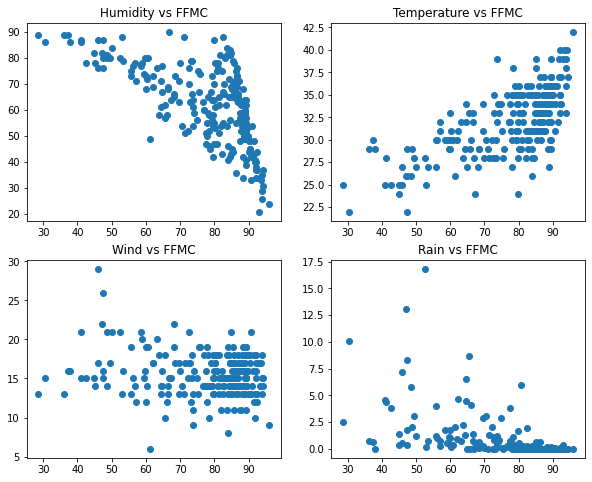

In [33]:
axs = plt.subplots(2, 2, figsize = (10, 8))

plt.subplot(2, 2, 1)
plt.scatter(forests.FFMC, forests.humid)
plt.title("Humidity vs FFMC")

plt.subplot(2, 2, 2)
plt.scatter(forests.FFMC, forests.temp)
plt.title("Temperature vs FFMC")

plt.subplot(2, 2, 3)
plt.scatter(forests.FFMC, forests.wind)
plt.title("Wind vs FFMC")

plt.subplot(2, 2, 4)
plt.scatter(forests.FFMC, forests.rain)
plt.title("Rain vs FFMC")

plt.show()